# IMPORT LIBRARIES

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

import glob as gb
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# SETUP PATHS AND CHECK DATA

In [25]:
# Get current working directory
os.getcwd()

'/kaggle/working'

In [26]:
# Define dataset paths
df_train = '/kaggle/input/realwaste-dataset/splited dataset/train'
df_val = '/kaggle/input/realwaste-dataset/splited dataset/val'
df_test = '/kaggle/input/realwaste-dataset/splited dataset/test'

# ANALYZE CLASS DISTRIBUTION

In [28]:
# Check class distribution to avoid imbalance issues
labels = os.listdir(df_train)
class_counts = {label: len(os.listdir(os.path.join(df_train, label))) for label in labels}
print("Class distribution:", class_counts)

# Compute class weights
class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(list(class_counts.keys())),
    y=np.concatenate([[label] * count for label, count in class_counts.items()])
)
class_weight = dict(enumerate(class_weight))
print("Computed class weights:", class_weight)

Class distribution: {'Metal': 474, 'Glass': 252, 'Paper': 300, 'Vegetation': 261, 'Cardboard': 276, 'Textile Trash': 190, 'Food Organics': 246, 'Plastic': 552, 'Miscellaneous Trash': 297}
Computed class weights: {0: 1.146537842190016, 1: 1.2863595302619693, 2: 1.255731922398589, 3: 0.6676043131739334, 4: 1.0654695099139544, 5: 1.0548148148148149, 6: 0.573268921095008, 7: 1.6654970760233918, 8: 1.2124308216262238}


# CHECK IMAGE SIZES

In [38]:
# Analyze training image sizes
import glob as gb
size = []

for label in os.listdir(df_train):
    images_paths = gb.glob(str(df_train +'/'+label+'/*.jpg'))

    for img_path in images_paths:
        img = plt.imread(img_path)
        img_shape = img.shape
        size.append(img_shape)

In [39]:
df = pd.DataFrame(size)
df.value_counts()

0    1    2
524  524  3    2848
Name: count, dtype: int64

In [40]:
# Analyze validation image sizes
size = []

for label in os.listdir(df_val):
    images_paths = gb.glob(str(df_val +'/'+label+'/*.jpg'))

    for img_path in images_paths:
        img = plt.imread(img_path)
        img_shape = img.shape
        size.append(img_shape)

In [41]:
df_va = pd.DataFrame(size)
df_va.value_counts()

0    1    2
524  524  3    949
Name: count, dtype: int64

In [42]:
# Analyze test image sizes
size = []

for label in os.listdir(df_test):
    images_paths = gb.glob(str(df_test +'/'+label+'/*.jpg'))

    for img_path in images_paths:
        img = plt.imread(img_path)
        img_shape = img.shape
        size.append(img_shape)

In [43]:
df_tes = pd.DataFrame(size)
df_tes.value_counts()

0    1    2
524  524  3    955
Name: count, dtype: int64

# CREATE DATA GENERATORS

In [29]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 15, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    brightness_range=[0.7, 1.3],  # New
    vertical_flip=True,  # New
    rescale = 1/255
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/realwaste-dataset/splited dataset/train',
    target_size=(256, 256),  #  Fix: Resizing
    batch_size = 64,
    class_mode = 'categorical'
)

Found 2848 images belonging to 9 classes.


In [30]:
train_batch = train_generator

In [31]:
# Validation generators
val_datagen = ImageDataGenerator(rescale = 1/255)
val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/realwaste-dataset/splited dataset/val',
    target_size=(256, 256),  #  Fix: Resizing
    batch_size = 32,
    class_mode = 'categorical'
)

Found 949 images belonging to 9 classes.


In [32]:
val_batch = val_generator

In [33]:
# Test generators
test_datagen = ImageDataGenerator(rescale = 1/255)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/realwaste-dataset/splited dataset/test',
    target_size=(256, 256),  #  Fix: Resizing
    batch_size = 32,
    class_mode = 'categorical'
)

Found 955 images belonging to 9 classes.


In [34]:
test_batch= test_generator

# BUILD TRANSFER LEARNING MODEL USING VGG

In [35]:
# 1. Load pre-trained VGG19 model 
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [36]:
# Freeze all layers first
base_model.trainable = False

In [37]:
# Unfreeze the last 5 layers
# Count total layers in base model
print(len(base_model.layers))   # for reference

# Unfreeze last 5 layers
for layer in base_model.layers[-5 : ] :
    layer.trainable = True

22


In [38]:
# Add custom top layers for  classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(9, activation='softmax')(x)

In [39]:
# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# COMPILE MODEL

In [40]:
# Custom focal loss function
from tensorflow.keras import backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.sum(loss, axis=1)
    return loss

In [22]:
# ignore
from tensorflow.keras.optimizers import Adam

# 4. Compile the model
model.compile(optimizer=Adam(learning_rate = 0.001), loss = focal_loss(), metrics = ['accuracy'])

In [41]:
# ignore

from tensorflow.keras.optimizers import Adam

# 4. Compile the model
model.compile(optimizer=Adam(learning_rate = 1e-7), loss = focal_loss(), metrics = ['accuracy'])

In [42]:
# ignore

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                             patience=2, min_lr=1e-7)
# Add to callbacks
callbacks = [early_stop, reduce_lr]

In [17]:
# Compile the model
model.compile(optimizer=Adam(learning_rate = 1e-3), loss = focal_loss(), metrics = ['accuracy'])

# SETUP CALLBACKS

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                             patience=2, min_lr=1e-5)
# Add to callbacks
callbacks = [early_stop, reduce_lr]

# TRAIN MODEL

In [19]:
batch_size = 64
epochs = 100
history = model.fit(train_generator, epochs = epochs, validation_data = val_batch,
                    class_weight = class_weight,  # Fix: Handling class imbalance
                    batch_size = batch_size)
, callbacks = [callbacks]

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 96s 845ms/step - accuracy: 0.1240 - loss: 0.4581 - val_accuracy: 0.1307 - val_loss: 0.4294
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 57s 590ms/step - accuracy: 0.1586 - loss: 0.4117 - val_accuracy: 0.3425 - val_loss: 0.2780
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 57s 591ms/step - accuracy: 0.3163 - loss: 0.2908 - val_accuracy: 0.4773 - val_loss: 0.2132
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 586ms/step - accuracy: 0.4282 - loss: 0.2161 - val_accuracy: 0.4995 - val_loss: 0.1783
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 57s 585ms/step - accuracy: 0.4790 - loss: 0.1928 - val_accuracy: 0.5595 - val_loss: 0.1618
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 587ms/step - accuracy: 0.5434 - loss: 0.1661 - val_accuracy: 0.5848 - val_loss: 0.1465
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 588ms/step - accuracy: 0.5683 - loss: 0.1562 - val_accuracy: 0.6038 - val_loss: 0.1534
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 583ms/step - accuracy: 0.6075 - loss: 0.1396 - val_accuracy

('callbacks', '=', '[callbacks]')

In [26]:
# Save the entire model (architecture + weights)
model.save('/kaggle/working/model_keras.h5')  # HDF5 format

# Later, load it back:
# loaded_model = tf.keras.models.load_model('/kaggle/working/model_keras.h5')

In [20]:
# Evaluate on train data
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"\nTrain Accuracy: {train_acc:.4f}")

# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")



Train Accuracy: 0.9322
Validation Accuracy: 0.7966


A little overfitting

In [21]:
val_generator.reset()

Test Set Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


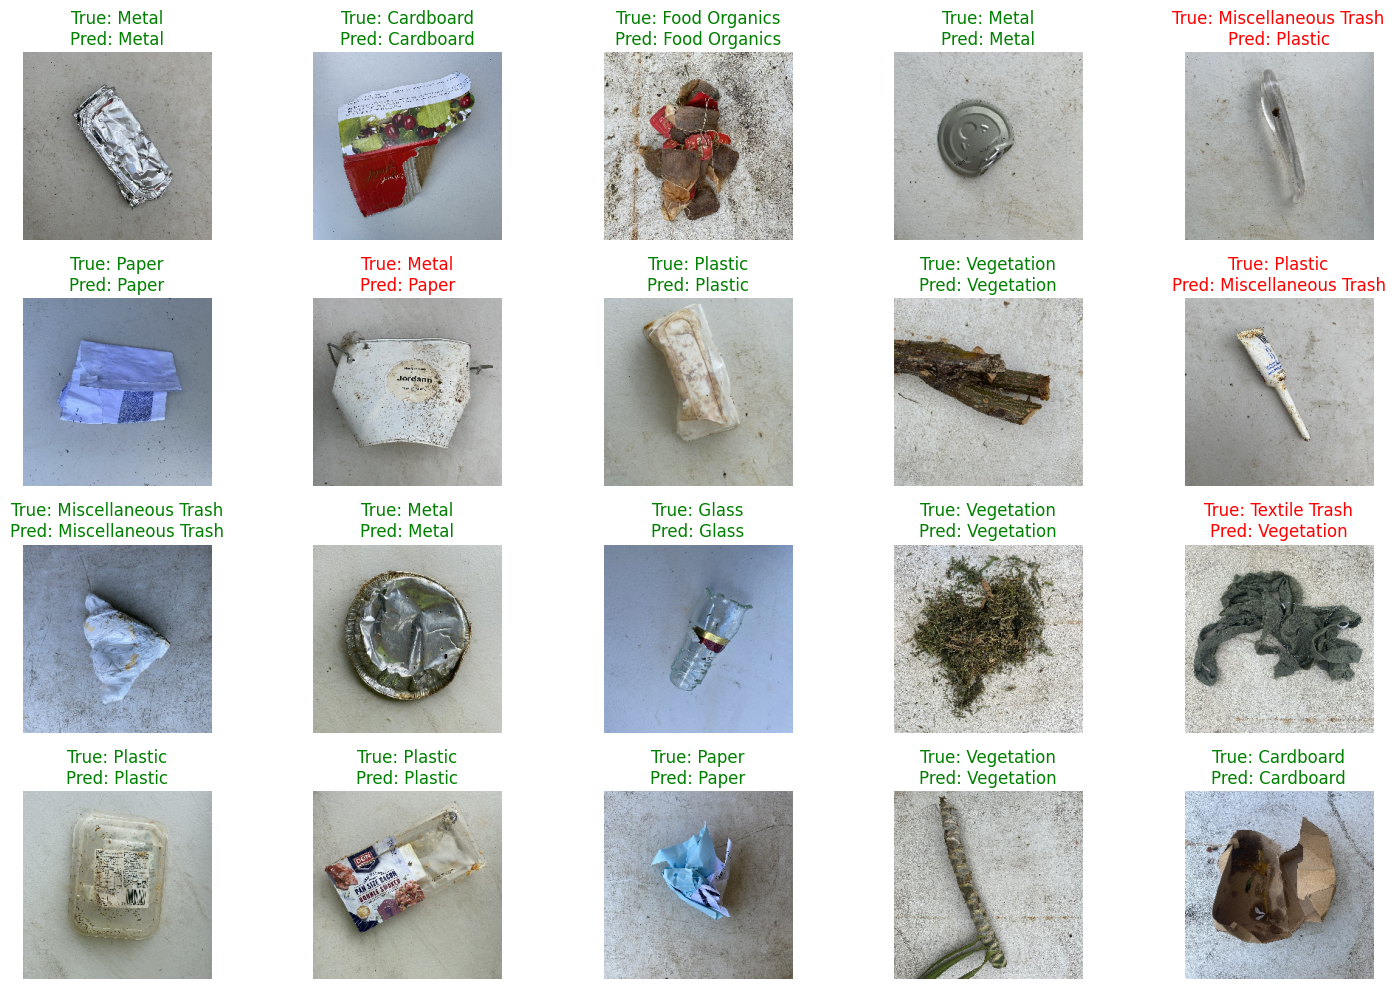

In [24]:
def plot_test_predictions(model, test_generator, num_images=20):
    class_names = list(test_generator.class_indices.keys())
    images, labels = next(test_generator)
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 5, i+1)
        plt.imshow(images[i])
        
        # Get prediction
        pred = model.predict(np.expand_dims(images[i], axis=0))
        pred_class = class_names[np.argmax(pred)]
        true_class = class_names[np.argmax(labels[i])]
        
        # Green if correct, red if wrong
        color = 'green' if pred_class == true_class else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Test Set Predictions:")
plot_test_predictions(model, test_generator)

stop

# OBJECT DEECTION

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 19.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

# Making Label for Dataset

In [3]:
import os

base_path = "/kaggle/input/realwaste-dataset"
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            print("✅ Found image:", os.path.join(root, file))
            break
    else:
        continue
    break

✅ Found image: /kaggle/input/realwaste-dataset/splited dataset/val/Metal/Metal_7.jpg


In [4]:
import shutil
import os

# Flatten into /kaggle/working/images_for_yolo_predict
src_folder = "/kaggle/input/realwaste-dataset/splited dataset/train"
dest_folder = "/kaggle/working/images_for_yolo_predict"
os.makedirs(dest_folder, exist_ok=True)

for class_name in os.listdir(src_folder):
    class_path = os.path.join(src_folder, class_name)
    for file in os.listdir(class_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(class_path, file)
            shutil.copy(full_path, os.path.join(dest_folder, f"{class_name}_{file}"))

print("✅ Copied images to:", dest_folder)

✅ Copied images to: /kaggle/working/images_for_yolo_predict


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.predict(
    source="/kaggle/working/images_for_yolo_predict",
    save_txt=True,
    save_conf=True
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 85.2MB/s]




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2848 /kaggle/working/images_for_yolo_predict/Cardboard_Cardboard_1.jpg: 640x640 (no detections), 7.9ms
image 2/2848 /kaggle/working/images_for_yolo_predict/Cardboard_Cardboard_10.jpg: 640x640 (no detections), 8.2ms
image 3/2848 /kaggle/working/images_for_yolo_predict/Cardboard_Cardboard_101.jpg: 640x640 1 hot dog, 7.9ms
image 4/2848 /kaggle/working/images_for_yolo_predict/Cardboard_Cardboard_102.jpg: 640x640 1 surfboard, 7.9ms
image 5/2848 /kag

In [ ]:
import shutil
import os

# Flatten into /kaggle/working/images_for_yolo_predict
src_folder = "/kaggle/input/realwaste-dataset/splited dataset/val"
dest_folder = "/kaggle/working/images_for_yolo_predict_val"
os.makedirs(dest_folder, exist_ok=True)

for class_name in os.listdir(src_folder):
    class_path = os.path.join(src_folder, class_name)
    for file in os.listdir(class_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(class_path, file)
            shutil.copy(full_path, os.path.join(dest_folder, f"{class_name}_{file}"))

print("✅ Copied images to:", dest_folder)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.predict(
    source="/kaggle/working/images_for_yolo_predict_val",
    save_txt=True,
    save_conf=True
)

In [ ]:
import shutil
import os

# Flatten into /kaggle/working/images_for_yolo_predict
src_folder = "/kaggle/input/realwaste-dataset/splited dataset/test"
dest_folder = "/kaggle/working/images_for_yolo_predict_test"
os.makedirs(dest_folder, exist_ok=True)

for class_name in os.listdir(src_folder):
    class_path = os.path.join(src_folder, class_name)
    for file in os.listdir(class_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(class_path, file)
            shutil.copy(full_path, os.path.join(dest_folder, f"{class_name}_{file}"))

print("✅ Copied images to:", dest_folder)

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.predict(
    source="/kaggle/working/images_for_yolo_predict_test",
    save_txt=True,
    save_conf=True
)

In [ ]:
# Define YAML content as a Python multi-line string
yaml_content = """
path: /kaggle/input/realwaste-dataset

train: /kaggle/working/images_for_yolo_predict
val: /kaggle/working/images_for_yolo_predict_val
test: /kaggle/working/images_for_yolo_predict_test

names:
  0: Cardboard
  1: Food Organics
  2: Glass
  3: Metal
  4: Miscellaneous Trash
  5: Paper
  6: Plastic
  7: Textile Trash
  8: Vegetation
"""

# Save it as data.yaml
with open("/kaggle/working/data.yaml", "w") as f:
    f.write(yaml_content)


In [ ]:
!cat /kaggle/working/data.yaml

In [ ]:
# Load a pre-trained YOLOv8n (nano) model
# This will be used as the base model for training
model = YOLO("yolov8n.pt")  

# Train the model using your custom dataset defined in data.yaml
# - data: path to the YAML file describing dataset structure
# - epochs: number of training iterations
# - imgsz: size to which input images will be resized (e.g. 640x640)
model.train(data="/kaggle/working/data.yaml", epochs=50, imgsz=640)


In [ ]:
from ultralytics import YOLO

# Load trained model
model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

# Run prediction on training images (or use val/test if preferred)
model.predict(source="/kaggle/working/images_for_yolo_predict", save=True, name="train_preview", conf=0.25)


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory containing predictions
pred_dir = "/kaggle/working/runs/detect/train_preview"
pred_images = sorted(os.listdir(pred_dir))[:20]  # Get first 20 images

# Plot them
for img_name in pred_images:
    img_path = os.path.join(pred_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)
    plt.show()